# Setup

In [21]:
jsoc_email = "hudson.harner657@topper.wku.edu"

In [22]:
%matplotlib inline

#import torch

import sunpy

import aiapy
import aiapy.data.sample as sample_data
from aiapy.calibrate import normalize_exposure, register, update_pointing

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation

import numpy as np

import scipy

# Set default fig size for matplotlib
plt.rcParams['figure.figsize'] = [8, 8]

from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries

import datetime

#import ffmpeg

# Flare Confirmation

In [23]:
# Only give me GOES>=C1.0 flares
results = Fido.search(a.Time('2022-01-25', '2022-01-26'), a.hek.FL, a.hek.FL.GOESCls > "C1.0")

results.show()

gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,fl_fluence,obs_meanwavel,frm_url,skel_chaincode,bound_chaincode,noposition,fl_fluenceunit,active,intensmax,frm_versionnumber,fl_peaktempunit,fl_halphaclass,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,skel_startc2,skel_startc1,fl_efoldtime,event_expires,fl_efoldtimeunit,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,skel_curvature,event_testflag,event_c2error,hrc_r,skel_nsteps,hgs_y,obs_title,fl_peakemunit,hgs_x,hcr_checked,frm_specificid,event_title,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,area_raw,concept,event_pixelunit,hgc_boundcc,fl_peakflux,hgc_x,hrc_a,event_peaktime,hgc_y,gs_galleryid,fl_goescls,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,fl_peakfluxunit,fl_peakem,rasterscantype,search_channelid,fl_peaktemp,hgs_bbox,area_unit,obs_lastprocessingdate,refs
str131,str1,str115,str5,str19,str12,object,str28,object,str130,object,str57,str41,str19,str1,str2,object,object,float64,str82,str1,str1,str5,str1,str4,object,object,str1,str1,object,str1,str186,str85,object,str1,str3,str1,str1,str30,object,str1,str1,str1,str1,str23,str1,object,object,str17,object,str9,str4,str1,float64,str1,float64,str61,str110,str1,str1,str1,object,str99,str20,object,object,object,str1,str1,str1,object,object,str19,str7,float64,float64,str4,object,str19,str19,object,str1,str1,object,str1,str1,str2,str66,str17,float64,int32,object,float64,str1,str1,object,str5,int32,float64,object,int32,str1,str1,int32,str4,str1,str1,str4,int32,str1,str19,str19,object,int32,object,int32,str4,object,str5,str1,str1,object,float64,float64,str19,int32,str1,str4,str13,str1,object,object,str1,str1,object,str1,str19,object,str66,str1,str1,object
,0,"POLYGON((-1.700701 -970.08462,1.700701 -970.08462,1.699337 969.21102,-1.699337 969.21102,-1.700701 -970.08462))",false,POINT(-176.49438 0),UTC-HGS-TOPO,None,POINT(0 93.41928),None,,None,"SSWIDL get_gev, ..., ngdc=0",POINT(0.095903494101659 0),2022-01-25T05:34:00,,FL,None,None,5e-08,http://www.swpc.noaa.gov/,,,true,,true,None,None,,,None,,,"POLYGON((93.60562 -89.9,-86.59438 -89.9,-86.59438 89.9,93.60562 89.9,93.60562 -89.9))",None,,XRA,,,SOL2022-01-25T05:34:00L184C090,None,9,,,,SWPC.Webmaster@noaa.gov,,None,None,SWPC,None,SWPC,GOES,,89.9000015258789,,-89.9000015258789,"U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center","POLYGON((0.995883 179.899552,0.995883 180.100448,0.994986 359.899542,0.994986 0.100458,0.995883 179.899552))",,,,None,,0.442000000000000004,None,None,None,,,,None,None,2022-01-25T00:00:00,degrees,93.41928,0.0,GOES,None,2022-05-25T15:58:14,autosubmission_swpc,None,0,,None,,,cm,ivo://helio-informatics.org/FL_SWPC_20220525_155812_20220125053400,SWPC,89.9000015258789,0,None,-89.9000015258789,,,None,false,90,0.095903494101659,None,0,,,0,true,,,GOES,90,1,93.4192800000000005,2022-01-25T06:05:00,None,0,None,0,GOES,None,Flare,,,None,-176.49438,0.0,2022-01-25T05:53:00,0,,C2.1,POINT(0 0),,None,None,,,None,,XRA,None,"POLYGON((-89.9 -89.9,89.9 -89

In [24]:
hek_results = results['hek']
print(hek_results["event_starttime"])
print(hek_results["event_peaktime"])
print(hek_results["event_endtime"])
print(hek_results["fl_goescls"])

  event_starttime  
-------------------
2022-01-25T05:34:00
2022-01-25T05:34:00
2022-01-25T10:21:00
2022-01-25T10:21:00
2022-01-25T22:38:00
2022-01-25T22:38:00
2022-01-25T23:38:00
2022-01-25T23:38:00
   event_peaktime  
-------------------
2022-01-25T05:53:00
2022-01-25T05:53:00
2022-01-25T10:29:00
2022-01-25T10:29:00
2022-01-25T22:44:00
2022-01-25T22:44:00
2022-01-25T23:49:00
2022-01-25T23:49:00
   event_endtime   
-------------------
2022-01-25T06:05:00
2022-01-25T06:05:00
2022-01-25T10:36:00
2022-01-25T10:36:00
2022-01-25T22:48:00
2022-01-25T22:48:00
2022-01-25T23:54:00
2022-01-25T23:54:00
fl_goescls
----------
      C2.1
      C2.1
      C3.7
      C3.7
      C2.1
      C2.1
      C9.9
      C9.9


In [25]:
# Pick a flare!
my_flare = hek_results[3]

# Look for GOES data during this time
results = Fido.search(a.Time(my_flare["event_starttime"], my_flare["event_endtime"]), a.Instrument.xrs)

results.show()

C:\Users\hharn\anaconda3\envs\PHYS299\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Start Time,End Time,Instrument,SatelliteNumber,Physobs,url,Source,Provider
Time,Time,str3,int32,str10,str161,str4,str4
2022-01-25 00:00:00.000,2022-01-25 23:59:59.999,XRS,16,irradiance,https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-flx1s_science/2022/01/sci_xrsf-l2-flx1s_g16_d20220125_v2-1-0.nc,GOES,NOAA
2022-01-25 00:00:00.000,2022-01-25 23:59:59.999,XRS,17,irradiance,https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes17/l2/data/xrsf-l2-flx1s_science/2022/01/sci_xrsf-l2-flx1s_g17_d20220125_v2-1-0.nc,GOES,NOAA


Now that we have picked our flare and have our GOES data for during that time frame, let's get started on visualization

In [40]:
# Find the flare image at peak time
#results = Fido.search(a.Time(my_flare["event_peaktime"], my_flare["event_peaktime"]),
#                      a.jsoc.Notify(jsoc_email), a.jsoc.Series('aia.lev1_euv_12s'))
#results.show()



starttime = '2022/1/25 23:59:00'
endtime = '2022/1/25 23:59:59'
# Find the flare image at peak time
results = Fido.search(a.Time(starttime, endtime),
                      a.jsoc.Notify(jsoc_email), a.jsoc.Series('aia.lev1_euv_12s'))

results.show()

T_REC,T_OBS,WAVELNTH,DATE,FSN,EXPTIME,QUALITY,ORIGIN,TELESCOP,INSTRUME,DATE__OBS,DATE-OBS,CAMERA,IMG_TYPE,EXPSDEV,INT_TIME,WAVEUNIT,WAVE_STR,FID,QUALLEV0,TOTVALS,DATAVALS,MISSVALS,PERCENTD,DATAMIN,DATAMAX,DATAMEDN,DATAMEAN,DATARMS,DATASKEW,DATAKURT,DATACENT,DATAP01,DATAP10,DATAP25,DATAP75,DATAP90,DATAP95,DATAP98,DATAP99,NSATPIX,OSCNMEAN,OSCNRMS,FLAT_REC,NSPIKES,CTYPE1,CUNIT1,CRVAL1,CDELT1,CRPIX1,CTYPE2,CUNIT2,CRVAL2,CDELT2,CRPIX2,CROTA2,R_SUN,MPO_REC,INST_ROT,IMSCL_MP,X0_MP,Y0_MP,ASD_REC,SAT_Y0,SAT_Z0,SAT_ROT,ACS_MODE,ACS_ECLP,ACS_SUNP,ACS_SAFE,ACS_CGT,ORB_REC,DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS,GAEX_OBS,GAEY_OBS,GAEZ_OBS,HAEX_OBS,HAEY_OBS,HAEZ_OBS,OBS_VR,OBS_VW,OBS_VN,CAR_ROT,CRLT_OBS,CRLN_OBS,HGLN_OBS,HGLT_OBS,ROI_NWIN,CALVER32,ROI_SUM,ROI_NAX1,ROI_NAY1,ROI_LLX1,ROI_LLY1,ROI_NAX2,ROI_NAY2,ROI_LLX2,ROI_LLY2,PIXLUNIT,DN_GAIN,EFF_AREA,EFF_AR_V,TEMPCCD,TEMPGT,TEMPSMIR,TEMPFPAD,ISPSNAME,ISPPKTIM,ISPPKTVN,AIVNMST,AIMGOTS,ASQHDR,ASQTNUM,ASQFSN,AIAHFSN,AECDELAY,AIAECTI,AIASEN,AIFDBID,AIMGOTSS,AIFCPS,AIFTSWTH,AIFRMLID,AIFTSID,AIHISMXB,AIHIS192,AIHIS348,AIHIS604,AIHIS860,AIFWEN,AIMGSHCE,AECTYPE,AECMODE,AISTATE,AIAECENF,AIFILTYP,AIMSHOBC,AIMSHOBE,AIMSHOTC,AIMSHOTE,AIMSHCBC,AIMSHCBE,AIMSHCTC,AIMSHCTE,AICFGDL1,AICFGDL2,AICFGDL3,AICFGDL4,AIFOENFL,AIMGFSN,AIMGTYP,AIAWVLEN,AIAGP1,AIAGP2,AIAGP3,AIAGP4,AIAGP5,AIAGP6,AIAGP7,AIAGP8,AIAGP9,AIAGP10,AGT1SVY,AGT1SVZ,AGT2SVY,AGT2SVZ,AGT3SVY,AGT3SVZ,AGT4SVY,AGT4SVZ,AIMGSHEN,KEYWDDOC,LVL_NUM,T_REC_step,T_REC_epoch
str20,str23,int64,str20,int64,float64,int64,str12,str7,str5,str23,str23,int64,str5,float64,float64,str8,str8,int64,int64,int64,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,str20,int64,str8,str6,float64,float64,float64,str8,str6,float64,float64,float64,float64,float64,str30,float64,float64,float64,float64,str29,float64,float64,float64,str7,str2,str3,str2,str3,str46,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str17,str23,str7,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str2,str6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str74,float64,float64,str23
2022-01-25T23:58:59Z,2022-01-25T23:59:00.57Z,94,2022-01-31T15:10:59Z,249582133,2.900801,0,SDO/JSOC-SDP,SDO/AIA,AIA_4,2022-01-25T23:58:59.12Z,2022-01-25T23:58:59.12Z,4,LIGHT,0.00017,3.164062,angstrom,94_THIN,0,0,16777216,16777216,0,100.0,-8,5700,1,2.0271,8.93,282.47,117425.48,1.67,-1.0,0.0,1.0,4.0,6.0,7.0,11.0,15.0,0,--,--,aia.flatfield[:#639],34499,HPLN-TAN,arcsec,0.0,0.600109,2071.042969,HPLT-TAN,arcsec,0.0,0.600109,2008.066895,-0.137633,1624.396606,aia.master_pointing3h[:#46570],-0.13761,0.600109,2070.042969,2007.066895,sdo.lev0_asd_0004[:#94558261],-5.99514,10.749868,-2.3e-05,SCIENCE,NO,YES,NO,GT3,sdo.fds_orbit_vectors[2022.01.25_23:59:00_UTC],149597870691.0,147269826701.47,696000000.0,974.815023,33155673.21,3965211.76,-25741582.96,-85895221166.26,119626133675.78,-31293189.57,3008.338257,29478.306383,-3514.20142,2253,-5.553246,173.333008,-0.012158,-5.553246,--,--,--,--,--,--,--,--,--,--,--,DN,18.3,0.282,3.0,-71.0,20.988,41.203,21.06,aia.lev0_isp_0011,2022-01-25T23:58:57.51Z,001.197,453,2021846377,3470807605,3,249582133,249582125,1535,0,0,241,12985,4,0,3338,40961,7,0,8341578,8386106,8388608,270,2900,2,ON,CLOSED,1,0,40.472,25.375999,54.287998,67.807999,2940.988037,2926.216064,2955.179932,2968.763916,0,23,87,236,1,7,0,9,0,0,0,0,0,0,0,279,343,748,-4,-10,-10,-16,0,0,58,122,4,https://www.lmsal.com/sdodocs/doc?

In [27]:
# Fetch the one image
downloaded_files = Fido.fetch(results)

Export request pending. [id=JSOC_20220606_5542, status=2]
Waiting for 0 seconds...
Export request pending. [id=JSOC_20220606_5542, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220606_5542, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220606_5542, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220606_5542, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220606_5542, status=1]
Waiting for 5 seconds...
INFO: max_splits keyword was passed and set to 1. [sunpy.net.jsoc.jsoc]
84 URLs found for download. Full request totalling 412MB


Files Downloaded:   0%|          | 0/84 [00:00<?, ?file/s]

In [28]:
# Given a filename in the standard format from JSOC download, find out what the wavelength is
def WavelengthFromFilename(filename):
    # Position of "." after wavelength
    end = filename.find(".image")
    if end < 0:
        return -1
    start = end - 1
    while filename[start] != '.':
        start = start - 1
    start = start + 1
    return int(filename[start:end])

# Given a filename in the standard format from JSOC download, find out what the time is
def TimeFromFilename(filename):
    start = filename.find("euv_12s")
    if start < 0:
        return -1
    start = start + 8
    end = start + 1
    while filename[end] != '.':
        end = end + 1
    end = end - 1
    return filename[start:end]

# Order of wavelengths from low to high temperature
wavelengthIndexDict = {304:0, 131:1, 171:2, 193:3, 211:4, 335:5, 94:6}

# And the inverse
wavelengthInvIndexDict = {v: k for k, v in wavelengthIndexDict.items()}

In [62]:
binnedFiles = [[], [], [], [], [], [], []]

for file in downloaded_files:
    wav = WavelengthFromFilename(file)
    
    # skip if it is a spike file
    if wav == -1:
        continue
    
    # otherwise bin it
    binnedFiles[wavelengthIndexDict[wav]].append(file)
    
print(binnedFiles[0][0])

C:\Users\hharn\sunpy\data\aia.lev1_euv_12s.2022-01-25T235907Z.304.image_lev1.fits


In [44]:
# Now also sort each bin by time

for wav_bin in binnedFiles:
    wav_bin.sort()
    

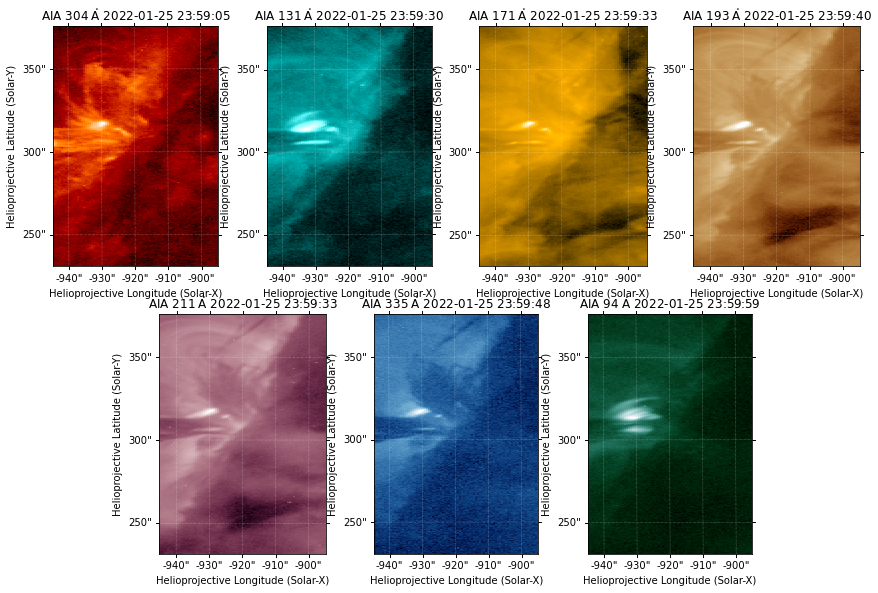

In [93]:
# Visualize the event to confirm the bounding box is fine

# TWEAK THESE:
bbox_add_left_deg = 4
bbox_add_right_deg = 4
bbox_add_up_deg = 3
bbox_add_down_deg = 3

#event_start = datetime.datetime.strptime(my_flare['event_starttime'], "%Y-%m-%dT%H:%M:%S")
#event_end = datetime.datetime.strptime(my_flare['event_endtime'], "%Y-%m-%dT%H:%M:%S")


event_start = datetime.datetime.strptime('2022-1-25T23:59:00', "%Y-%m-%dT%H:%M:%S")
event_end = datetime.datetime.strptime('2022-1-25T23:59:59', "%Y-%m-%dT%H:%M:%S")
event_length = event_end - event_start

top_right = SkyCoord(my_flare["boundbox_c1ur"] + bbox_add_right_deg , my_flare["boundbox_c2ur"] + bbox_add_up_deg, unit="deg", frame=sunpy.coordinates.frames.HeliographicStonyhurst)
bottom_left = SkyCoord(my_flare["boundbox_c1ll"] - bbox_add_left_deg, my_flare["boundbox_c2ll"] - bbox_add_down_deg, unit="deg", frame=sunpy.coordinates.frames.HeliographicStonyhurst)

mymaps = sunpy.map.Map([f[0] for f in binnedFiles])
mymaps1 = sunpy.map.Map([f[1] for f in binnedFiles])


submaps = [mymap.submap(bottom_left, top_right=top_right) for mymap in mymaps]
submaps1 = [mymap.submap(bottom_left, top_right=top_right) for mymap in mymaps1]

idx_time = datetime.datetime.strptime(TimeFromFilename(binnedFiles[0][0]), "%Y-%m-%dT%H%M%S")

fig, ax = plt.subplots(figsize=(15,15))

ax1 = plt.subplot2grid((3,8), (1,0), colspan=2, projection=submaps[0])
ax2 = plt.subplot2grid((3,8), (1,2), colspan=2, projection=submaps[1])
ax3 = plt.subplot2grid((3,8), (1,4), colspan=2, projection=submaps[2])
ax4 = plt.subplot2grid((3,8), (1,6), colspan=2, projection=submaps[3])
ax5 = plt.subplot2grid((3,8), (2,1), colspan=2, projection=submaps[4])
ax6 = plt.subplot2grid((3,8), (2,3), colspan=2, projection=submaps[5])
ax7 = plt.subplot2grid((3,8), (2,5), colspan=2, projection=submaps[6])

#ax11 = plt.subplot2grid((3,8), (1,0), colspan=2, projection=submaps1[0])
#ax21 = plt.subplot2grid((3,8), (1,2), colspan=2, projection=submaps1[1])
#ax31 = plt.subplot2grid((3,8), (1,4), colspan=2, projection=submaps1[2])
#ax41 = plt.subplot2grid((3,8), (1,6), colspan=2, projection=submaps1[3])
#ax51 = plt.subplot2grid((3,8), (2,1), colspan=2, projection=submaps1[4])
#ax61 = plt.subplot2grid((3,8), (2,3), colspan=2, projection=submaps1[5])
#ax71 = plt.subplot2grid((3,8), (2,5), colspan=2, projection=submaps1[6])

axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
#axes_list1 = [ax11, ax21, ax31, ax41, ax51, ax61, ax71]

for m_idx, m in enumerate(submaps):
    m.plot(axes=axes_list[m_idx], aspect=0.5)
    
#for m_idx, m in enumerate(submaps1):
#    m.plot(axes=axes_list1[m_idx], aspect=0.5)
    

#fig.tight_layout(h_pad=0.05,w_pad=2.5)

#fig.show()



In [80]:
print(binnedFiles[0][0])
print(mymaps[0])
print(mymaps1[0])

C:\Users\hharn\sunpy\data\aia.lev1_euv_12s.2022-01-25T235907Z.304.image_lev1.fits
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 4
Detector:		 AIA
Measurement:		 304.0 Angstrom
Wavelength:		 304.0 Angstrom
Observation Date:	 2022-01-25 23:59:05
Exposure Time:		 2.90204 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.60016501 0.60016501] arcsec / pix
Reference Pixel:	 [2069.58300781 2005.8828125 ] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[-2,  1,  1, ..., -2,  0,  0],
       [-1,  0,  1, ..., -1,  1, -1],
       [ 2,  2,  1, ..., -2,  2,  3],
       ...,
       [-2,  0,  0, ...,  1,  0,  1],
       [-1,  1,  0, ...,  0, -2,  2],
       [ 1,  0,  0, ...,  2,  0,  3]], dtype=int16)
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 4
Detector:		 AIA
Measurement:		 304.0 Angstrom
Wavelength:		 304.0 Angstrom
Observation Date:	 2022-01-25 23:59:41
Exposure Time:		 2.902039 s
Dimension:		 [4096. 4096.] pix
Coordinate Sys

In [ ]:


#Intensity for all wavelengths at any given point
I = []
#for i in range(0,7):
#    I.append(submaps[i].data[120,20])

for i in range(0,7):
    for y in range(0,242):
        for x in range(0,84):
            I.append(submaps[i].data[y,x])

print(I)


Once we have a good bounding box around the flare via the above cell, then we can request only that specific cutout of the sun from JSOC.

# Cutout

In [ ]:
#requesting specific cutouts
cutout = a.jsoc.Cutout(
    submaps[0].bottom_left_coord,
    submaps[0].top_right_coord,
    tracking=True
)
cutout_res = Fido.search(
    a.Time(my_flare["event_starttime"], my_flare["event_endtime"]),
    a.jsoc.Notify(jsoc_email), a.jsoc.Series('aia.lev1_euv_12s'),
    a.jsoc.Segment.image,
    cutout,
)

cutout_res.show()

# Datacube Creation

In [ ]:
# Fetch the cutouts
cutout_downloaded_files = Fido.fetch(cutout_res)

In [ ]:
cutout_downloaded_files.errors

In [ ]:
binnedFiles = [[], [], [], [], [], [], []]

for file in cutout_downloaded_files:
    wav = WavelengthFromFilename(file)
    
    # skip if it is a spike file
    if wav == -1:
        continue
    
    # otherwise bin it
    binnedFiles[wavelengthIndexDict[wav]].append(file)
    
# Now also sort each bin by time

for wav_bin in binnedFiles:
    wav_bin.sort()

In [ ]:
# Our data is binned by wavelength, then the 2nd axis is time. Flip it so we bin time first

binnedFilesT = np.array(binnedFiles).T

# Figure out the size of the data cube
array_tuple = binnedFilesT.shape
m = sunpy.map.Map(binnedFilesT[0, 0]).data.T.shape
array_tuple = array_tuple + m

# Generate filename as outlined in fileformat.txt

filename = "flare_" + my_flare["event_starttime"].replace(":", "") + '_' + str(array_tuple[0]) + '_' + str(array_tuple[1]) + '_' + str(array_tuple[2]) + '_' + str(array_tuple[3]) + '.fits'

out_arr = np.zeros(array_tuple, dtype=np.int16)

for t_idx, time_bin in enumerate(binnedFilesT):
    for idx, wavelength in enumerate(time_bin):
        m = sunpy.map.Map(wavelength)

        out_arr[t_idx, idx] = m.data.T

astropy.io.fits.writeto(filename, out_arr)

# Loading a Datacube

In [ ]:
from ast import literal_eval as make_tuple

def load_datacube(filename):    
    return astropy.io.fits.getdata(filename)

In [ ]:
new_data = load_datacube('C:/Users/jboil/Documents/Physics/Solar Flare/Notebooks/flare_2022-01-25T233800_81_7_83_240.fits')

In [ ]:
# Now we can use list slicing on it.
# This specifically is all the times, the 0th wavelength and 0, 0 pixel from bottom left
# A time series, if you will :)
#new_data[t,lambda,x,y]
new_data[:,0,0,0]